In [1]:
pip install git+https://github.com/google-research/timesfm


  Cloning https://github.com/google-research/timesfm to /tmp/pip-req-build-_qydyc0u
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/timesfm /tmp/pip-req-build-_qydyc0u
  Resolved https://github.com/google-research/timesfm to commit dbe0fa528d58aa2946a88125a102a3417fe664b6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requireme

In [1]:
!pip install yfinance
!pip install utilsforecast


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

In [3]:
import timesfm
import gc
import numpy as np
import pandas as pd
from timesfm import patched_decoder
from timesfm import data_loader
import yfinance as yf

In [4]:
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [5]:
# Loading TimesFM pretrained checkpoint
tfm = timesfm.TimesFm(
    context_len=64,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="gpu",
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 4.34 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.64 seconds.
Jitting decoding.
Jitted decoding in 22.20 seconds.


In [21]:
import pandas as pd
import yfinance as yf

# لیستی از نمادهای سهام معروف
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'V', 'NFLX']

# بارگذاری داده‌های بورسی روزانه برای هر سهام
all_data = []

for idx, ticker in enumerate(tickers, start=1):
    data = yf.download(ticker, start='2000-01-01', end='2023-01-01', interval='1d')
    if data.empty:
        print(f"Failed to download data for {ticker}")
        continue
    data.index = pd.to_datetime(data.index)
    data = data.resample('1D').ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'date', 'Close': 'y'}, inplace=True)
    data['ticker'] = idx  # جایگزین کردن نام سهام با یک عدد یکتا
    final_cols = ["date", "y", "ticker"]
    data = data[final_cols]
    all_data.append(data)

# ترکیب داده‌های تمام سهام‌ها در یک DataFrame
combined_data = pd.concat(all_data)

# حذف مقادیر NaN
combined_data = combined_data.ffill()

# ذخیره‌سازی داده‌ها در یک فایل CSV
data_path = 'stocks_data.csv'
combined_data.to_csv(data_path, index=False)

print(f"Number of records: {len(combined_data)}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Number of records: 70072


In [22]:
data

,date,y,ticker
0,2002-05-23,1.196429,10
1,2002-05-24,1.210000,10
2,2002-05-25,1.210000,10
3,2002-05-26,1.210000,10
4,2002-05-27,1.210000,10
...,...,...,...
7522,2022-12-26,294.959991,10
7523,2022-12-27,284.170013,10
7524,2022-12-28,276.880005,10
7525,2022-12-29,291.119995,10


In [27]:
freq = 'D'
context_len = 64
pred_len = 1
batch_size = 1

# Define train, validation, and test boundaries
train_boundary = int(len(data) * 0.8)
val_boundary = int(len(data) * 0.95)

In [13]:
train_boundary

6021

In [25]:
ts_cols = [col for col in data.columns if col != "date"]


num_ts = len(ts_cols)
# Create TimeSeriesdata loader
dtl = data_loader.TimeSeriesdata(
      data_path=data_path,
      datetime_col="date",
      num_cov_cols=None,
      cat_cov_cols=None,
      ts_cols=ts_cols,
      train_range=[0, train_boundary],
      val_range=[train_boundary, val_boundary],
      test_range=[val_boundary, len(data)],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,  # Change as per requirement
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

In [26]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    pass
print(tbatch[0].shape)

11912it [00:10, 1164.24it/s]


(1, 2, 64)


# MAE on the test split for the pretrained TimesFM model

In [28]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]

    actuals = batch[3]

    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]

    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

377it [00:06, 54.98it/s]


MAE: 0.05422919988632202


# Fine-tuning the model

In [29]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [30]:
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [31]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

In [32]:

@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [33]:

task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [34]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: Tesla T4


In [35]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    print
    past_ts = batch[0].reshape(batch_size * num_ts, -1)
    actual_ts = batch[3].reshape(batch_size * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

In [36]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

In [37]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [38]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [39]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 100
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='/content/g'

In [40]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [41]:
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])
            mean_loss = np.mean(eval_losses)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 0.03251823037862778
Starting eval.



0it [00:00, ?it/s]
1it [00:10, 10.74s/it]
10it [00:10,  1.27it/s]
19it [00:10,  2.90it/s]
29it [00:11,  5.37it/s]
40it [00:11,  9.04it/s]
51it [00:11, 13.81it/s]
62it [00:11, 19.85it/s]
72it [00:11, 26.46it/s]
82it [00:11, 34.14it/s]
93it [00:11, 43.80it/s]
104it [00:11, 53.73it/s]
115it [00:11, 63.10it/s]
126it [00:12, 71.40it/s]
137it [00:12, 78.67it/s]
148it [00:12, 84.75it/s]
159it [00:12, 89.49it/s]
170it [00:12, 93.15it/s]
181it [00:12, 95.81it/s]
192it [00:12, 97.83it/s]
203it [00:12, 99.30it/s]
214it [00:12, 100.17it/s]
225it [00:12, 100.69it/s]
236it [00:13, 101.12it/s]
247it [00:13, 101.50it/s]
258it [00:13, 101.90it/s]
269it [00:13, 102.12it/s]
280it [00:13, 102.28it/s]
291it [00:13, 102.34it/s]
302it [00:13, 102.54it/s]
313it [00:13, 102.45it/s]
324it [00:13, 102.34it/s]
335it [00:14, 102.20it/s]
346it [00:14, 102.28it/s]
357it [00:14, 102.41it/s]
368it [00:14, 102.48it/s]
379it [00:14, 102.54it/s]
390it [00:14, 102.62it/s]
401it [00:14, 102.64it/s]
412it [00:14, 102.55it/

Eval loss at step 0: 0.16972047090530396


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


997it [01:46, 30.41it/s]

Train loss at step 1000: 0.021446820348501205
Starting eval.



0it [00:00, ?it/s]
8it [00:00, 75.18it/s]
17it [00:00, 82.12it/s]
28it [00:00, 91.62it/s]
39it [00:00, 97.27it/s]
50it [00:00, 99.32it/s]
61it [00:00, 100.48it/s]
72it [00:00, 101.32it/s]
83it [00:00, 101.75it/s]
94it [00:00, 101.63it/s]
105it [00:01, 53.45it/s]
116it [00:01, 62.68it/s]
127it [00:01, 71.20it/s]
138it [00:01, 78.60it/s]
149it [00:01, 84.64it/s]
160it [00:01, 89.40it/s]
171it [00:02, 93.15it/s]
182it [00:02, 95.43it/s]
193it [00:02, 97.20it/s]
204it [00:02, 98.33it/s]
215it [00:02, 99.63it/s]
226it [00:02, 100.59it/s]
237it [00:02, 101.23it/s]
248it [00:02, 101.72it/s]
259it [00:02, 102.15it/s]
270it [00:02, 102.40it/s]
281it [00:03, 102.41it/s]
292it [00:03, 102.25it/s]
303it [00:03, 101.98it/s]
314it [00:03, 102.07it/s]
325it [00:03, 102.33it/s]
336it [00:03, 102.44it/s]
347it [00:03, 102.61it/s]
358it [00:03, 102.66it/s]
369it [00:03, 102.71it/s]
380it [00:04, 102.80it/s]
391it [00:04, 101.39it/s]
402it [00:04, 102.66it/s]
413it [00:04, 102.53it/s]
424it [00:04, 102.

Eval loss at step 1000: 0.17998741567134857


1005it [01:58,  1.54it/s]

patience: 1


1998it [02:33, 28.30it/s]

Train loss at step 2000: 0.01686030626296997
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 109.89it/s]
23it [00:00, 106.06it/s]
34it [00:00, 104.75it/s]
45it [00:00, 104.09it/s]
56it [00:00, 103.75it/s]
67it [00:00, 103.44it/s]
78it [00:00, 103.40it/s]
89it [00:00, 103.33it/s]
100it [00:00, 102.39it/s]
111it [00:01, 102.41it/s]
122it [00:01, 102.55it/s]
133it [00:01, 102.56it/s]
144it [00:01, 102.62it/s]
155it [00:01, 102.53it/s]
166it [00:01, 102.70it/s]
177it [00:01, 103.10it/s]
188it [00:01, 103.03it/s]
199it [00:01, 102.71it/s]
210it [00:02, 102.31it/s]
221it [00:02, 102.59it/s]
232it [00:02, 102.67it/s]
243it [00:02, 102.73it/s]
254it [00:02, 102.85it/s]
265it [00:02, 102.88it/s]
276it [00:02, 102.92it/s]
287it [00:02, 102.84it/s]
298it [00:02, 102.68it/s]
309it [00:03, 98.97it/s] 
320it [00:03, 101.17it/s]
331it [00:03, 101.87it/s]
342it [00:03, 102.27it/s]
353it [00:03, 101.19it/s]
364it [00:03, 103.05it/s]
375it [00:03, 103.03it/s]
386it [00:03, 102.97it/s]
397it [00:03, 102.77it/s]
408it [00:03, 96.60it/s] 
419it [00:04, 99.71it/s]
4

Eval loss at step 2000: 0.16838590800762177


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


3000it [03:51, 30.48it/s]

Train loss at step 3000: 0.00943310558795929
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 109.63it/s]
23it [00:00, 105.28it/s]
34it [00:00, 103.99it/s]
45it [00:00, 103.29it/s]
56it [00:00, 103.02it/s]
67it [00:00, 102.85it/s]
78it [00:00, 102.51it/s]
89it [00:00, 102.63it/s]
100it [00:00, 101.83it/s]
111it [00:01, 101.96it/s]
122it [00:01, 102.01it/s]
133it [00:01, 102.15it/s]
144it [00:01, 102.19it/s]
155it [00:01, 102.24it/s]
166it [00:01, 102.32it/s]
177it [00:01, 102.31it/s]
188it [00:01, 102.32it/s]
199it [00:01, 102.02it/s]
210it [00:02, 102.03it/s]
221it [00:02, 102.07it/s]
232it [00:02, 102.14it/s]
243it [00:02, 102.20it/s]
254it [00:02, 102.22it/s]
265it [00:02, 102.34it/s]
276it [00:02, 102.39it/s]
287it [00:02, 102.32it/s]
298it [00:02, 102.20it/s]
309it [00:03, 102.06it/s]
320it [00:03, 102.11it/s]
331it [00:03, 102.12it/s]
342it [00:03, 102.24it/s]
353it [00:03, 102.25it/s]
364it [00:03, 102.33it/s]
375it [00:03, 102.35it/s]
386it [00:03, 102.35it/s]
397it [00:03, 102.28it/s]
408it [00:03, 102.10it/s]
419it [00:04, 102.15it/s]


Eval loss at step 3000: 0.16285640001296997


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


3997it [05:14, 18.95it/s]

Train loss at step 4000: 0.012281177565455437
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 76.70it/s]
19it [00:00, 88.08it/s]
29it [00:00, 91.35it/s]
39it [00:00, 92.53it/s]
50it [00:00, 97.86it/s]
61it [00:00, 99.42it/s]
72it [00:00, 100.41it/s]
83it [00:00, 98.86it/s] 
94it [00:00, 101.50it/s]
105it [00:01, 100.58it/s]
116it [00:01, 101.79it/s]
127it [00:01, 101.94it/s]
138it [00:01, 101.68it/s]
149it [00:01, 99.48it/s] 
161it [00:01, 102.46it/s]
172it [00:01, 102.51it/s]
183it [00:01, 102.32it/s]
194it [00:01, 101.99it/s]
205it [00:02, 101.85it/s]
216it [00:02, 101.81it/s]
227it [00:02, 101.89it/s]
238it [00:02, 101.98it/s]
249it [00:02, 102.15it/s]
260it [00:02, 102.23it/s]
271it [00:02, 102.29it/s]
282it [00:02, 102.24it/s]
293it [00:02, 102.01it/s]
304it [00:03, 101.89it/s]
315it [00:03, 101.92it/s]
326it [00:03, 101.86it/s]
337it [00:03, 102.07it/s]
348it [00:03, 102.08it/s]
359it [00:03, 102.25it/s]
370it [00:03, 102.24it/s]
381it [00:03, 102.27it/s]
392it [00:03, 102.16it/s]
403it [00:03, 102.05it/s]
414it [00:04, 101.92it/s]
425it [0

Eval loss at step 4000: 0.17842409014701843


4005it [05:26,  1.53it/s]

patience: 1


4998it [06:02, 17.43it/s]

Train loss at step 5000: 0.006760193966329098
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 110.25it/s]
24it [00:00, 106.15it/s]
35it [00:00, 104.96it/s]
46it [00:00, 104.43it/s]
57it [00:00, 104.17it/s]
68it [00:00, 103.95it/s]
79it [00:00, 103.74it/s]
90it [00:00, 103.35it/s]
101it [00:00, 102.73it/s]
112it [00:01, 102.92it/s]
123it [00:01, 103.12it/s]
134it [00:01, 103.22it/s]
145it [00:01, 103.29it/s]
156it [00:01, 103.39it/s]
167it [00:01, 103.48it/s]
178it [00:01, 103.47it/s]
189it [00:01, 103.36it/s]
200it [00:01, 102.86it/s]
211it [00:02, 102.82it/s]
222it [00:02, 103.03it/s]
233it [00:02, 103.12it/s]
244it [00:02, 103.08it/s]
255it [00:02, 103.25it/s]
266it [00:02, 103.26it/s]
277it [00:02, 103.35it/s]
288it [00:02, 103.22it/s]
299it [00:02, 103.02it/s]
310it [00:03, 99.65it/s] 
321it [00:03, 101.48it/s]
332it [00:03, 102.01it/s]
343it [00:03, 102.53it/s]
354it [00:03, 102.75it/s]
365it [00:03, 102.93it/s]
376it [00:03, 103.17it/s]
387it [00:03, 103.07it/s]
398it [00:03, 102.94it/s]
409it [00:03, 102.83it/s]
420it [00:04, 102.84it/s]


Eval loss at step 5000: 0.15858888626098633


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


5999it [07:20, 30.55it/s]

Train loss at step 6000: 0.021296311169862747
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 101.31it/s]
22it [00:00, 102.01it/s]
33it [00:00, 102.28it/s]
44it [00:00, 102.55it/s]
55it [00:00, 102.62it/s]
66it [00:00, 102.67it/s]
77it [00:00, 102.70it/s]
88it [00:00, 102.71it/s]
99it [00:00, 101.68it/s]
110it [00:01, 101.49it/s]
121it [00:01, 101.96it/s]
132it [00:01, 102.13it/s]
143it [00:01, 102.38it/s]
154it [00:01, 102.49it/s]
165it [00:01, 102.54it/s]
176it [00:01, 102.64it/s]
187it [00:01, 102.52it/s]
198it [00:01, 102.09it/s]
209it [00:02, 102.03it/s]
220it [00:02, 102.11it/s]
231it [00:02, 102.23it/s]
242it [00:02, 102.36it/s]
253it [00:02, 102.51it/s]
264it [00:02, 102.61it/s]
275it [00:02, 102.68it/s]
286it [00:02, 102.58it/s]
297it [00:02, 102.35it/s]
308it [00:03, 102.14it/s]
319it [00:03, 102.13it/s]
330it [00:03, 102.35it/s]
341it [00:03, 102.30it/s]
352it [00:03, 102.57it/s]
363it [00:03, 102.63it/s]
374it [00:03, 102.64it/s]
385it [00:03, 102.61it/s]
396it [00:03, 102.51it/s]
407it [00:03, 102.33it/s]
418it [00:04, 102.36it/s]
4

Eval loss at step 6000: 0.1647455096244812


6005it [07:31,  1.42it/s]

patience: 1


6997it [08:07, 30.52it/s]

Train loss at step 7000: 0.07535340636968613
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 110.30it/s]
24it [00:00, 106.13it/s]
35it [00:00, 104.56it/s]
46it [00:00, 104.42it/s]
57it [00:00, 103.96it/s]
68it [00:00, 103.67it/s]
79it [00:00, 99.63it/s] 
89it [00:00, 81.27it/s]
98it [00:01, 73.32it/s]
106it [00:01, 68.44it/s]
114it [00:01, 61.13it/s]
121it [00:01, 59.36it/s]
131it [00:01, 68.26it/s]
143it [00:01, 80.12it/s]
154it [00:01, 86.50it/s]
164it [00:01, 85.95it/s]
175it [00:02, 91.45it/s]
186it [00:02, 95.34it/s]
197it [00:02, 97.82it/s]
208it [00:02, 98.95it/s]
219it [00:02, 99.92it/s]
230it [00:02, 100.26it/s]
241it [00:02, 99.94it/s] 
252it [00:02, 101.18it/s]
263it [00:02, 97.06it/s] 
273it [00:03, 94.57it/s]
284it [00:03, 97.69it/s]
295it [00:03, 99.70it/s]
306it [00:03, 101.25it/s]
317it [00:03, 101.58it/s]
328it [00:03, 101.99it/s]
339it [00:03, 102.47it/s]
350it [00:03, 102.63it/s]
361it [00:03, 101.20it/s]
372it [00:04, 101.53it/s]
383it [00:04, 102.87it/s]
394it [00:04, 103.21it/s]
405it [00:04, 103.85it/s]
416it [00:04, 103.

Eval loss at step 7000: 0.16255921125411987


7005it [08:19,  1.56it/s]

patience: 2


7998it [08:55, 29.59it/s]

Train loss at step 8000: 0.11754021048545837
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.25it/s]
21it [00:00, 103.55it/s]
32it [00:00, 103.55it/s]
43it [00:00, 103.31it/s]
54it [00:00, 103.20it/s]
65it [00:00, 102.92it/s]
76it [00:00, 102.84it/s]
87it [00:00, 102.95it/s]
98it [00:00, 102.44it/s]
109it [00:01, 102.31it/s]
120it [00:01, 102.55it/s]
131it [00:01, 102.68it/s]
142it [00:01, 102.77it/s]
153it [00:01, 102.82it/s]
164it [00:01, 102.84it/s]
175it [00:01, 102.70it/s]
186it [00:01, 102.67it/s]
197it [00:01, 102.62it/s]
208it [00:02, 102.47it/s]
219it [00:02, 102.44it/s]
230it [00:02, 102.74it/s]
241it [00:02, 102.80it/s]
252it [00:02, 102.88it/s]
263it [00:02, 102.89it/s]
274it [00:02, 102.86it/s]
285it [00:02, 102.75it/s]
296it [00:02, 102.54it/s]
307it [00:02, 102.52it/s]
318it [00:03, 102.46it/s]
329it [00:03, 102.68it/s]
340it [00:03, 102.65it/s]
351it [00:03, 102.80it/s]
362it [00:03, 102.95it/s]
373it [00:03, 102.91it/s]
384it [00:03, 102.76it/s]
395it [00:03, 102.76it/s]
406it [00:03, 102.67it/s]
417it [00:04, 102.63it/s]
42

Eval loss at step 8000: 0.16029717028141022


8006it [09:06,  1.56it/s]

patience: 3


9000it [09:42, 30.10it/s]

Train loss at step 9000: 0.05058729276061058
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 107.65it/s]
22it [00:00, 103.05it/s]
33it [00:00, 103.24it/s]
44it [00:00, 103.30it/s]
55it [00:00, 103.11it/s]
66it [00:00, 103.24it/s]
77it [00:00, 103.13it/s]
88it [00:00, 103.18it/s]
99it [00:00, 102.68it/s]
110it [00:01, 102.61it/s]
121it [00:01, 102.80it/s]
132it [00:01, 102.89it/s]
143it [00:01, 102.97it/s]
154it [00:01, 103.04it/s]
165it [00:01, 102.74it/s]
176it [00:01, 103.18it/s]
187it [00:01, 103.10it/s]
198it [00:01, 102.86it/s]
209it [00:02, 102.80it/s]
220it [00:02, 102.84it/s]
231it [00:02, 102.91it/s]
242it [00:02, 103.01it/s]
253it [00:02, 103.07it/s]
264it [00:02, 103.06it/s]
275it [00:02, 103.07it/s]
286it [00:02, 103.07it/s]
297it [00:02, 102.87it/s]
308it [00:02, 102.82it/s]
319it [00:03, 102.84it/s]
330it [00:03, 102.88it/s]
341it [00:03, 102.96it/s]
352it [00:03, 103.05it/s]
363it [00:03, 102.93it/s]
374it [00:03, 103.08it/s]
385it [00:03, 103.03it/s]
396it [00:03, 102.96it/s]
407it [00:03, 102.88it/s]
418it [00:04, 102.86it/s]
4

Eval loss at step 9000: 0.15157021582126617


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


9997it [10:57, 30.56it/s]

Train loss at step 10000: 0.25030505657196045
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 104.14it/s]
22it [00:00, 101.67it/s]
33it [00:00, 101.82it/s]
44it [00:00, 102.00it/s]
55it [00:00, 102.15it/s]
66it [00:00, 102.16it/s]
77it [00:00, 101.96it/s]
88it [00:00, 102.11it/s]
99it [00:00, 101.21it/s]
110it [00:01, 101.22it/s]
121it [00:01, 101.46it/s]
132it [00:01, 101.73it/s]
143it [00:01, 101.87it/s]
154it [00:01, 102.01it/s]
165it [00:01, 102.07it/s]
176it [00:01, 101.99it/s]
187it [00:01, 101.96it/s]
198it [00:01, 101.55it/s]
209it [00:02, 101.45it/s]
220it [00:02, 101.56it/s]
231it [00:02, 101.77it/s]
242it [00:02, 101.86it/s]
253it [00:02, 101.99it/s]
264it [00:02, 102.05it/s]
275it [00:02, 102.10it/s]
286it [00:02, 101.94it/s]
297it [00:02, 101.78it/s]
308it [00:03, 101.57it/s]
319it [00:03, 101.67it/s]
330it [00:03, 101.75it/s]
341it [00:03, 101.90it/s]
352it [00:03, 101.92it/s]
363it [00:03, 102.07it/s]
374it [00:03, 102.03it/s]
385it [00:03, 102.02it/s]
396it [00:03, 101.87it/s]
407it [00:03, 101.77it/s]
418it [00:04, 101.71it/s]
4

Eval loss at step 10000: 0.1536979079246521


10001it [11:09,  1.13it/s]

patience: 1


11000it [11:45, 30.33it/s]

Train loss at step 11000: 0.16444462537765503
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 95.59it/s]
20it [00:00, 85.43it/s]
32it [00:00, 96.17it/s]
43it [00:00, 98.77it/s]
54it [00:00, 100.30it/s]
65it [00:00, 101.18it/s]
76it [00:00, 101.87it/s]
87it [00:00, 102.32it/s]
98it [00:00, 101.67it/s]
109it [00:01, 101.84it/s]
120it [00:01, 101.96it/s]
131it [00:01, 102.46it/s]
142it [00:01, 102.66it/s]
153it [00:01, 102.78it/s]
164it [00:01, 102.87it/s]
175it [00:01, 102.91it/s]
186it [00:01, 102.90it/s]
197it [00:01, 102.58it/s]
208it [00:02, 102.39it/s]
219it [00:02, 102.35it/s]
230it [00:02, 102.60it/s]
241it [00:02, 102.67it/s]
252it [00:02, 102.80it/s]
263it [00:02, 102.86it/s]
274it [00:02, 102.90it/s]
285it [00:02, 102.90it/s]
296it [00:02, 102.70it/s]
307it [00:03, 102.52it/s]
318it [00:03, 102.35it/s]
329it [00:03, 102.50it/s]
340it [00:03, 102.75it/s]
351it [00:03, 102.83it/s]
362it [00:03, 102.90it/s]
373it [00:03, 102.86it/s]
384it [00:03, 102.85it/s]
395it [00:03, 102.73it/s]
406it [00:03, 102.59it/s]
417it [00:04, 102.55it/s]
428it

Eval loss at step 11000: 0.15143370628356934


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


11912it [12:39, 15.68it/s]

__________________Epoch: 1__________________



88it [00:02, 30.40it/s]

Train loss at step 12000: 0.07788274437189102
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 109.30it/s]
22it [00:00, 105.71it/s]
33it [00:00, 104.50it/s]
44it [00:00, 103.88it/s]
55it [00:00, 103.64it/s]
66it [00:00, 103.44it/s]
77it [00:00, 103.33it/s]
88it [00:00, 103.11it/s]
99it [00:00, 102.61it/s]
110it [00:01, 102.38it/s]
121it [00:01, 102.57it/s]
132it [00:01, 102.78it/s]
143it [00:01, 102.77it/s]
154it [00:01, 102.91it/s]
165it [00:01, 102.92it/s]
176it [00:01, 103.11it/s]
187it [00:01, 103.02it/s]
198it [00:01, 102.74it/s]
209it [00:02, 102.58it/s]
220it [00:02, 102.61it/s]
231it [00:02, 102.69it/s]
242it [00:02, 102.74it/s]
253it [00:02, 102.60it/s]
264it [00:02, 103.00it/s]
275it [00:02, 103.03it/s]
286it [00:02, 103.04it/s]
297it [00:02, 102.90it/s]
308it [00:02, 102.82it/s]
319it [00:03, 102.75it/s]
330it [00:03, 102.78it/s]
341it [00:03, 102.78it/s]
352it [00:03, 102.92it/s]
363it [00:03, 103.00it/s]
374it [00:03, 102.92it/s]
385it [00:03, 103.05it/s]
396it [00:03, 102.94it/s]
407it [00:03, 102.84it/s]
418it [00:04, 102.79it/s]
4

Eval loss at step 12000: 0.15893962979316711


92it [00:14,  1.14it/s]

patience: 1


1088it [00:49, 28.74it/s]

Train loss at step 13000: 0.01918061636388302
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 109.17it/s]
22it [00:00, 105.43it/s]
33it [00:00, 104.31it/s]
44it [00:00, 103.74it/s]
55it [00:00, 103.39it/s]
66it [00:00, 103.36it/s]
77it [00:00, 103.25it/s]
88it [00:00, 103.20it/s]
99it [00:00, 102.23it/s]
110it [00:01, 102.23it/s]
121it [00:01, 102.39it/s]
132it [00:01, 102.57it/s]
143it [00:01, 102.62it/s]
154it [00:01, 102.68it/s]
165it [00:01, 102.82it/s]
176it [00:01, 102.94it/s]
187it [00:01, 102.86it/s]
198it [00:01, 102.50it/s]
209it [00:02, 102.36it/s]
220it [00:02, 102.31it/s]
231it [00:02, 102.53it/s]
242it [00:02, 102.66it/s]
253it [00:02, 102.62it/s]
264it [00:02, 102.82it/s]
275it [00:02, 102.81it/s]
286it [00:02, 102.77it/s]
297it [00:02, 102.59it/s]
308it [00:02, 102.52it/s]
319it [00:03, 102.41it/s]
330it [00:03, 102.48it/s]
341it [00:03, 102.61it/s]
352it [00:03, 102.66it/s]
363it [00:03, 102.62it/s]
374it [00:03, 102.87it/s]
385it [00:03, 102.79it/s]
396it [00:03, 102.59it/s]
407it [00:03, 102.51it/s]
418it [00:04, 102.42it/s]
4

Eval loss at step 13000: 0.15917380154132843


1093it [01:01,  1.31it/s]

patience: 2


2088it [01:37, 28.58it/s]

Train loss at step 14000: 0.04082465171813965
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.23it/s]
21it [00:00, 101.63it/s]
32it [00:00, 102.64it/s]
43it [00:00, 102.76it/s]
54it [00:00, 103.03it/s]
65it [00:00, 103.13it/s]
76it [00:00, 103.09it/s]
87it [00:00, 103.21it/s]
98it [00:00, 102.41it/s]
109it [00:01, 102.28it/s]
120it [00:01, 102.60it/s]
131it [00:01, 102.82it/s]
142it [00:01, 98.83it/s] 
152it [00:01, 94.21it/s]
162it [00:01, 94.26it/s]
173it [00:01, 97.05it/s]
184it [00:01, 99.25it/s]
195it [00:01, 100.36it/s]
206it [00:02, 101.05it/s]
217it [00:02, 101.73it/s]
228it [00:02, 102.18it/s]
239it [00:02, 101.24it/s]
250it [00:02, 98.21it/s] 
262it [00:02, 101.55it/s]
273it [00:02, 102.61it/s]
284it [00:02, 102.77it/s]
295it [00:02, 102.85it/s]
306it [00:03, 102.83it/s]
317it [00:03, 102.98it/s]
328it [00:03, 102.98it/s]
339it [00:03, 102.81it/s]
350it [00:03, 102.89it/s]
361it [00:03, 102.96it/s]
372it [00:03, 102.83it/s]
383it [00:03, 102.99it/s]
394it [00:03, 103.02it/s]
405it [00:03, 103.02it/s]
416it [00:04, 103.05it/s]
427it 

Eval loss at step 14000: 0.15382416546344757


2095it [01:48,  1.46it/s]

patience: 3


3087it [02:24, 20.96it/s]

Train loss at step 15000: 0.019828952848911285
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 107.36it/s]
22it [00:00, 104.72it/s]
33it [00:00, 103.96it/s]
44it [00:00, 103.76it/s]
55it [00:00, 103.54it/s]
66it [00:00, 103.36it/s]
77it [00:00, 103.01it/s]
88it [00:00, 103.05it/s]
99it [00:00, 102.46it/s]
110it [00:01, 102.35it/s]
121it [00:01, 102.74it/s]
132it [00:01, 102.86it/s]
143it [00:01, 102.88it/s]
154it [00:01, 103.01it/s]
165it [00:01, 102.98it/s]
176it [00:01, 102.87it/s]
187it [00:01, 102.87it/s]
198it [00:01, 102.63it/s]
209it [00:02, 102.55it/s]
220it [00:02, 102.61it/s]
231it [00:02, 102.81it/s]
242it [00:02, 102.83it/s]
253it [00:02, 103.04it/s]
264it [00:02, 103.00it/s]
275it [00:02, 102.78it/s]
286it [00:02, 102.87it/s]
297it [00:02, 102.57it/s]
308it [00:02, 102.69it/s]
319it [00:03, 102.62it/s]
330it [00:03, 102.77it/s]
341it [00:03, 102.76it/s]
352it [00:03, 103.05it/s]
363it [00:03, 102.99it/s]
374it [00:03, 102.99it/s]
385it [00:03, 102.90it/s]
396it [00:03, 102.78it/s]
407it [00:03, 102.66it/s]
418it [00:04, 102.64it/s]
4

Eval loss at step 15000: 0.15637794137001038


3094it [02:35,  1.50it/s]

patience: 4


4085it [03:11, 20.97it/s]

Train loss at step 16000: 0.016919253394007683
Starting eval.



0it [00:00, ?it/s]
12it [00:00, 109.13it/s]
23it [00:00, 105.91it/s]
34it [00:00, 104.47it/s]
45it [00:00, 103.96it/s]
56it [00:00, 103.54it/s]
67it [00:00, 103.18it/s]
78it [00:00, 103.06it/s]
89it [00:00, 102.99it/s]
100it [00:00, 102.19it/s]
111it [00:01, 102.24it/s]
122it [00:01, 102.34it/s]
133it [00:01, 102.52it/s]
144it [00:01, 102.64it/s]
155it [00:01, 102.72it/s]
166it [00:01, 102.65it/s]
177it [00:01, 102.63it/s]
188it [00:01, 102.63it/s]
199it [00:01, 102.29it/s]
210it [00:02, 102.30it/s]
221it [00:02, 102.38it/s]
232it [00:02, 102.51it/s]
243it [00:02, 102.62it/s]
254it [00:02, 102.64it/s]
265it [00:02, 102.65it/s]
276it [00:02, 102.55it/s]
287it [00:02, 102.61it/s]
298it [00:02, 102.44it/s]
309it [00:03, 102.29it/s]
320it [00:03, 102.42it/s]
331it [00:03, 102.37it/s]
342it [00:03, 102.62it/s]
353it [00:03, 102.66it/s]
364it [00:03, 102.67it/s]
375it [00:03, 102.66it/s]
386it [00:03, 102.62it/s]
397it [00:03, 102.52it/s]
408it [00:03, 102.30it/s]
419it [00:04, 102.40it/s]


Eval loss at step 16000: 0.14997178316116333


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


5085it [04:35, 30.15it/s]

Train loss at step 17000: 0.08992704004049301
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 89.40it/s]
20it [00:00, 97.00it/s]
31it [00:00, 100.94it/s]
42it [00:00, 101.67it/s]
53it [00:00, 102.04it/s]
64it [00:00, 102.40it/s]
75it [00:00, 102.56it/s]
86it [00:00, 102.51it/s]
97it [00:00, 101.85it/s]
108it [00:01, 101.73it/s]
119it [00:01, 102.00it/s]
130it [00:01, 102.22it/s]
141it [00:01, 102.50it/s]
152it [00:01, 102.65it/s]
163it [00:01, 102.72it/s]
174it [00:01, 102.67it/s]
185it [00:01, 102.80it/s]
196it [00:01, 102.46it/s]
207it [00:02, 102.25it/s]
218it [00:02, 102.28it/s]
229it [00:02, 102.37it/s]
240it [00:02, 102.55it/s]
251it [00:02, 102.72it/s]
262it [00:02, 102.76it/s]
273it [00:02, 102.71it/s]
284it [00:02, 102.71it/s]
295it [00:02, 102.53it/s]
306it [00:02, 102.36it/s]
317it [00:03, 102.34it/s]
328it [00:03, 102.40it/s]
339it [00:03, 102.40it/s]
350it [00:03, 102.72it/s]
361it [00:03, 102.69it/s]
372it [00:03, 102.75it/s]
383it [00:03, 102.72it/s]
394it [00:03, 102.62it/s]
405it [00:03, 102.50it/s]
416it [00:04, 102.44it/s]
427i

Eval loss at step 17000: 0.15830035507678986


5093it [04:46,  1.58it/s]

patience: 1


6088it [05:22, 26.41it/s]

Train loss at step 18000: 0.0037604845128953457
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 103.88it/s]
22it [00:00, 103.69it/s]
33it [00:00, 103.73it/s]
44it [00:00, 103.75it/s]
55it [00:00, 103.69it/s]
66it [00:00, 103.63it/s]
77it [00:00, 103.65it/s]
88it [00:00, 103.73it/s]
99it [00:00, 102.90it/s]
110it [00:01, 102.24it/s]
121it [00:01, 102.91it/s]
132it [00:01, 103.11it/s]
143it [00:01, 103.32it/s]
154it [00:01, 103.52it/s]
165it [00:01, 103.07it/s]
176it [00:01, 103.72it/s]
187it [00:01, 103.61it/s]
198it [00:01, 103.28it/s]
209it [00:02, 102.82it/s]
220it [00:02, 102.84it/s]
231it [00:02, 103.18it/s]
242it [00:02, 103.15it/s]
253it [00:02, 103.56it/s]
264it [00:02, 103.58it/s]
275it [00:02, 98.70it/s] 
286it [00:02, 101.24it/s]
297it [00:02, 102.80it/s]
308it [00:02, 101.74it/s]
319it [00:03, 101.11it/s]
330it [00:03, 98.29it/s] 
340it [00:03, 97.97it/s]
351it [00:03, 100.64it/s]
362it [00:03, 102.29it/s]
373it [00:03, 102.67it/s]
384it [00:03, 102.36it/s]
395it [00:03, 103.17it/s]
406it [00:03, 103.13it/s]
417it [00:04, 102.84it/s]
42

Eval loss at step 18000: 0.14965009689331055


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


7086it [07:16, 30.11it/s]

Train loss at step 19000: 0.0028844005428254604
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 108.74it/s]
22it [00:00, 105.46it/s]
33it [00:00, 104.40it/s]
44it [00:00, 103.84it/s]
55it [00:00, 103.75it/s]
66it [00:00, 103.56it/s]
77it [00:00, 103.47it/s]
88it [00:00, 103.20it/s]
99it [00:00, 102.48it/s]
110it [00:01, 102.43it/s]
121it [00:01, 102.66it/s]
132it [00:01, 102.82it/s]
143it [00:01, 102.89it/s]
154it [00:01, 102.97it/s]
165it [00:01, 103.19it/s]
176it [00:01, 103.14it/s]
187it [00:01, 103.10it/s]
198it [00:01, 102.75it/s]
209it [00:02, 102.59it/s]
220it [00:02, 102.69it/s]
231it [00:02, 102.82it/s]
242it [00:02, 102.93it/s]
253it [00:02, 102.94it/s]
264it [00:02, 103.11it/s]
275it [00:02, 103.29it/s]
286it [00:02, 103.17it/s]
297it [00:02, 102.95it/s]
308it [00:02, 102.73it/s]
319it [00:03, 102.69it/s]
330it [00:03, 102.84it/s]
341it [00:03, 102.95it/s]
352it [00:03, 102.97it/s]
363it [00:03, 103.16it/s]
374it [00:03, 103.27it/s]
385it [00:03, 103.25it/s]
396it [00:03, 103.04it/s]
407it [00:03, 102.76it/s]
418it [00:04, 102.86it/s]
4

Eval loss at step 19000: 0.1465301513671875


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


8088it [09:03, 28.30it/s]

Train loss at step 20000: 0.021379627287387848
Starting eval.



0it [00:00, ?it/s]
9it [00:00, 80.01it/s]
20it [00:00, 95.70it/s]
31it [00:00, 99.03it/s]
42it [00:00, 100.65it/s]
53it [00:00, 101.48it/s]
64it [00:00, 101.93it/s]
75it [00:00, 102.31it/s]
86it [00:00, 102.51it/s]
97it [00:00, 101.46it/s]
108it [00:01, 101.36it/s]
119it [00:01, 101.81it/s]
130it [00:01, 102.12it/s]
141it [00:01, 102.34it/s]
152it [00:01, 102.50it/s]
163it [00:01, 102.62it/s]
174it [00:01, 102.71it/s]
185it [00:01, 102.71it/s]
196it [00:01, 102.35it/s]
207it [00:02, 102.06it/s]
218it [00:02, 102.15it/s]
229it [00:02, 102.26it/s]
240it [00:02, 102.46it/s]
251it [00:02, 102.62it/s]
262it [00:02, 102.72it/s]
273it [00:02, 102.76it/s]
284it [00:02, 102.73it/s]
295it [00:02, 102.53it/s]
306it [00:03, 102.30it/s]
317it [00:03, 102.26it/s]
328it [00:03, 102.38it/s]
339it [00:03, 102.42it/s]
350it [00:03, 102.69it/s]
361it [00:03, 102.69it/s]
372it [00:03, 102.75it/s]
383it [00:03, 102.74it/s]
394it [00:03, 102.68it/s]
405it [00:03, 102.49it/s]
416it [00:04, 102.40it/s]
427it

Eval loss at step 20000: 0.1507604569196701


8095it [09:14,  1.45it/s]

patience: 1


9086it [09:49, 30.47it/s]

Train loss at step 21000: 0.04689686372876167
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 107.70it/s]
22it [00:00, 105.30it/s]
33it [00:00, 104.40it/s]
44it [00:00, 104.02it/s]
55it [00:00, 103.87it/s]
66it [00:00, 103.56it/s]
77it [00:00, 103.54it/s]
88it [00:00, 103.39it/s]
99it [00:00, 102.89it/s]
110it [00:01, 102.61it/s]
121it [00:01, 102.91it/s]
132it [00:01, 103.06it/s]
143it [00:01, 103.19it/s]
154it [00:01, 103.30it/s]
165it [00:01, 103.24it/s]
176it [00:01, 103.33it/s]
187it [00:01, 103.34it/s]
198it [00:01, 103.02it/s]
209it [00:02, 102.89it/s]
220it [00:02, 102.84it/s]
231it [00:02, 102.90it/s]
242it [00:02, 103.03it/s]
253it [00:02, 103.15it/s]
264it [00:02, 103.19it/s]
275it [00:02, 103.20it/s]
286it [00:02, 103.22it/s]
297it [00:02, 103.09it/s]
308it [00:02, 102.94it/s]
319it [00:03, 102.89it/s]
330it [00:03, 102.83it/s]
341it [00:03, 103.01it/s]
352it [00:03, 103.16it/s]
363it [00:03, 103.27it/s]
374it [00:03, 101.88it/s]
385it [00:03, 100.73it/s]
396it [00:03, 103.04it/s]
407it [00:03, 103.00it/s]
418it [00:04, 102.32it/s]
4

Eval loss at step 21000: 0.14722616970539093


9094it [10:01,  1.61it/s]

patience: 2


10088it [10:36, 30.32it/s]

Train loss at step 22000: 0.0033143525943160057
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 108.77it/s]
22it [00:00, 105.40it/s]
33it [00:00, 104.33it/s]
44it [00:00, 103.95it/s]
55it [00:00, 103.52it/s]
66it [00:00, 103.41it/s]
77it [00:00, 103.35it/s]
88it [00:00, 103.31it/s]
99it [00:00, 102.67it/s]
110it [00:01, 102.62it/s]
121it [00:01, 102.76it/s]
132it [00:01, 101.76it/s]
143it [00:01, 64.82it/s] 
152it [00:01, 67.48it/s]
163it [00:01, 75.71it/s]
174it [00:01, 82.51it/s]
185it [00:02, 87.94it/s]
196it [00:02, 92.05it/s]
207it [00:02, 95.20it/s]
218it [00:02, 97.39it/s]
229it [00:02, 99.21it/s]
240it [00:02, 99.81it/s]
251it [00:02, 100.46it/s]
262it [00:02, 101.29it/s]
273it [00:02, 101.79it/s]
284it [00:02, 102.18it/s]
295it [00:03, 102.54it/s]
306it [00:03, 102.75it/s]
317it [00:03, 102.79it/s]
328it [00:03, 102.85it/s]
339it [00:03, 102.64it/s]
350it [00:03, 102.64it/s]
361it [00:03, 102.69it/s]
372it [00:03, 102.82it/s]
383it [00:03, 102.89it/s]
394it [00:04, 103.01it/s]
405it [00:04, 103.08it/s]
416it [00:04, 103.13it/s]
427it [00:

Eval loss at step 22000: 0.14693087339401245


10092it [10:48,  1.12it/s]

patience: 3


11088it [11:24, 29.57it/s]

Train loss at step 23000: 0.0035145634319633245
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 109.30it/s]
22it [00:00, 105.47it/s]
33it [00:00, 104.79it/s]
44it [00:00, 104.42it/s]
55it [00:00, 104.13it/s]
66it [00:00, 103.90it/s]
77it [00:00, 103.64it/s]
88it [00:00, 103.42it/s]
99it [00:00, 102.85it/s]
110it [00:01, 102.78it/s]
121it [00:01, 102.93it/s]
132it [00:01, 102.95it/s]
143it [00:01, 103.16it/s]
154it [00:01, 103.23it/s]
165it [00:01, 103.28it/s]
176it [00:01, 103.31it/s]
187it [00:01, 103.15it/s]
198it [00:01, 102.98it/s]
209it [00:02, 102.86it/s]
220it [00:02, 102.89it/s]
231it [00:02, 103.02it/s]
242it [00:02, 103.17it/s]
253it [00:02, 103.24it/s]
264it [00:02, 103.25it/s]
275it [00:02, 103.29it/s]
286it [00:02, 103.23it/s]
297it [00:02, 102.99it/s]
308it [00:02, 102.92it/s]
319it [00:03, 102.92it/s]
330it [00:03, 103.04it/s]
341it [00:03, 103.01it/s]
352it [00:03, 103.18it/s]
363it [00:03, 103.27it/s]
374it [00:03, 103.22it/s]
385it [00:03, 103.24it/s]
396it [00:03, 103.04it/s]
407it [00:03, 103.01it/s]
418it [00:04, 103.01it/s]
4

Eval loss at step 23000: 0.1461431235074997


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


11912it [12:50, 15.46it/s]

__________________Epoch: 2__________________



176it [00:06, 30.23it/s]

Train loss at step 24000: 0.02560201659798622
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 108.05it/s]
22it [00:00, 104.70it/s]
33it [00:00, 103.83it/s]
44it [00:00, 103.41it/s]
55it [00:00, 103.15it/s]
66it [00:00, 103.07it/s]
77it [00:00, 102.91it/s]
88it [00:00, 102.89it/s]
99it [00:00, 101.82it/s]
110it [00:01, 101.81it/s]
121it [00:01, 102.06it/s]
132it [00:01, 102.27it/s]
143it [00:01, 102.39it/s]
154it [00:01, 102.38it/s]
165it [00:01, 102.63it/s]
176it [00:01, 102.68it/s]
187it [00:01, 102.59it/s]
198it [00:01, 102.21it/s]
209it [00:02, 102.11it/s]
220it [00:02, 102.17it/s]
231it [00:02, 102.30it/s]
242it [00:02, 102.52it/s]
253it [00:02, 102.57it/s]
264it [00:02, 102.51it/s]
275it [00:02, 102.67it/s]
286it [00:02, 102.65it/s]
297it [00:02, 102.38it/s]
308it [00:03, 102.19it/s]
319it [00:03, 102.17it/s]
330it [00:03, 102.17it/s]
341it [00:03, 100.30it/s]
352it [00:03, 101.62it/s]
363it [00:03, 96.65it/s] 
374it [00:03, 100.09it/s]
385it [00:03, 100.80it/s]
396it [00:03, 101.22it/s]
407it [00:03, 101.53it/s]
418it [00:04, 101.77it/s]
4

Eval loss at step 24000: 0.1498059779405594


180it [00:17,  1.13it/s]

patience: 1


1175it [00:53, 28.55it/s]

Train loss at step 25000: 0.553694486618042
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 109.19it/s]
22it [00:00, 105.76it/s]
33it [00:00, 104.48it/s]
44it [00:00, 103.85it/s]
55it [00:00, 103.58it/s]
66it [00:00, 103.40it/s]
77it [00:00, 103.07it/s]
88it [00:00, 103.29it/s]
99it [00:00, 102.24it/s]
110it [00:01, 102.15it/s]
121it [00:01, 102.30it/s]
132it [00:01, 102.51it/s]
143it [00:01, 102.58it/s]
154it [00:01, 102.69it/s]
165it [00:01, 102.88it/s]
176it [00:01, 102.95it/s]
187it [00:01, 102.90it/s]
198it [00:01, 102.54it/s]
209it [00:02, 102.30it/s]
220it [00:02, 102.34it/s]
231it [00:02, 102.38it/s]
242it [00:02, 102.42it/s]
253it [00:02, 102.78it/s]
264it [00:02, 102.88it/s]
275it [00:02, 102.90it/s]
286it [00:02, 102.94it/s]
297it [00:02, 102.68it/s]
308it [00:02, 102.47it/s]
319it [00:03, 102.38it/s]
330it [00:03, 102.43it/s]
341it [00:03, 102.56it/s]
352it [00:03, 102.55it/s]
363it [00:03, 102.82it/s]
374it [00:03, 102.93it/s]
385it [00:03, 102.87it/s]
396it [00:03, 102.72it/s]
407it [00:03, 102.55it/s]
418it [00:04, 102.46it/s]
4

Eval loss at step 25000: 0.14557795226573944


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


2176it [02:35, 20.77it/s]

Train loss at step 26000: 0.015225149691104889
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 105.61it/s]
22it [00:00, 104.29it/s]
33it [00:00, 103.75it/s]
44it [00:00, 103.66it/s]
55it [00:00, 103.53it/s]
66it [00:00, 103.42it/s]
77it [00:00, 103.01it/s]
88it [00:00, 103.01it/s]
99it [00:00, 102.36it/s]
110it [00:01, 102.39it/s]
121it [00:01, 102.61it/s]
132it [00:01, 102.81it/s]
143it [00:01, 102.93it/s]
154it [00:01, 103.06it/s]
165it [00:01, 102.99it/s]
176it [00:01, 103.02it/s]
187it [00:01, 102.97it/s]
198it [00:01, 102.72it/s]
209it [00:02, 102.62it/s]
220it [00:02, 102.59it/s]
231it [00:02, 102.82it/s]
242it [00:02, 102.94it/s]
253it [00:02, 103.02it/s]
264it [00:02, 103.03it/s]
275it [00:02, 103.03it/s]
286it [00:02, 102.97it/s]
297it [00:02, 102.74it/s]
308it [00:02, 102.62it/s]
319it [00:03, 101.82it/s]
330it [00:03, 99.57it/s] 
341it [00:03, 101.48it/s]
352it [00:03, 102.43it/s]
363it [00:03, 102.66it/s]
374it [00:03, 102.83it/s]
385it [00:03, 102.78it/s]
396it [00:03, 102.76it/s]
407it [00:03, 102.68it/s]
418it [00:04, 102.66it/s]
4

Eval loss at step 26000: 0.14428845047950745


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


3175it [04:16, 27.46it/s]

Train loss at step 27000: 0.012556868605315685
Starting eval.



0it [00:00, ?it/s]
10it [00:00, 97.83it/s]
21it [00:00, 100.50it/s]
32it [00:00, 101.63it/s]
43it [00:00, 102.21it/s]
54it [00:00, 102.47it/s]
65it [00:00, 102.49it/s]
76it [00:00, 102.74it/s]
87it [00:00, 102.93it/s]
98it [00:00, 102.23it/s]
109it [00:01, 102.12it/s]
120it [00:01, 102.21it/s]
131it [00:01, 102.51it/s]
142it [00:01, 102.60it/s]
153it [00:01, 102.75it/s]
164it [00:01, 102.83it/s]
175it [00:01, 102.86it/s]
186it [00:01, 102.86it/s]
197it [00:01, 102.66it/s]
208it [00:02, 102.49it/s]
219it [00:02, 102.44it/s]
230it [00:02, 102.43it/s]
241it [00:02, 102.56it/s]
252it [00:02, 101.20it/s]
263it [00:02, 103.25it/s]
274it [00:02, 102.88it/s]
285it [00:02, 102.35it/s]
296it [00:02, 102.41it/s]
307it [00:02, 102.41it/s]
318it [00:03, 102.41it/s]
329it [00:03, 102.53it/s]
340it [00:03, 102.62it/s]
351it [00:03, 102.60it/s]
362it [00:03, 102.76it/s]
373it [00:03, 102.94it/s]
384it [00:03, 81.69it/s] 
393it [00:04, 66.85it/s]
401it [00:04, 60.19it/s]
413it [00:04, 71.56it/s]
424it

Eval loss at step 27000: 0.1458490788936615


3182it [04:27,  1.48it/s]

patience: 1


4173it [05:03, 30.63it/s]

Train loss at step 28000: 0.04838339239358902
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 106.42it/s]
22it [00:00, 100.42it/s]
34it [00:00, 105.11it/s]
45it [00:00, 104.45it/s]
56it [00:00, 104.10it/s]
67it [00:00, 103.84it/s]
78it [00:00, 103.76it/s]
89it [00:00, 103.66it/s]
100it [00:00, 102.79it/s]
111it [00:01, 102.65it/s]
122it [00:01, 102.83it/s]
133it [00:01, 102.89it/s]
144it [00:01, 103.17it/s]
155it [00:01, 103.29it/s]
166it [00:01, 103.37it/s]
177it [00:01, 103.38it/s]
188it [00:01, 103.34it/s]
199it [00:01, 102.93it/s]
210it [00:02, 102.78it/s]
221it [00:02, 102.79it/s]
232it [00:02, 102.94it/s]
243it [00:02, 103.01it/s]
254it [00:02, 103.19it/s]
265it [00:02, 103.21it/s]
276it [00:02, 103.17it/s]
287it [00:02, 103.34it/s]
298it [00:02, 103.17it/s]
309it [00:02, 102.93it/s]
320it [00:03, 102.91it/s]
331it [00:03, 102.91it/s]
342it [00:03, 102.88it/s]
353it [00:03, 103.11it/s]
364it [00:03, 103.16it/s]
375it [00:03, 103.20it/s]
386it [00:03, 103.29it/s]
397it [00:03, 103.19it/s]
408it [00:03, 103.08it/s]
419it [00:04, 102.96it/s]


Eval loss at step 28000: 0.1448565125465393


4181it [05:15,  1.57it/s]

patience: 2


5174it [05:51, 17.02it/s]

Train loss at step 29000: 0.011023531667888165
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 103.65it/s]
22it [00:00, 103.40it/s]
33it [00:00, 103.36it/s]
44it [00:00, 103.31it/s]
55it [00:00, 103.34it/s]
66it [00:00, 103.34it/s]
77it [00:00, 103.20it/s]
88it [00:00, 103.21it/s]
99it [00:00, 102.53it/s]
110it [00:01, 102.48it/s]
121it [00:01, 102.56it/s]
132it [00:01, 102.86it/s]
143it [00:01, 102.86it/s]
154it [00:01, 103.02it/s]
165it [00:01, 103.14it/s]
176it [00:01, 103.10it/s]
187it [00:01, 103.14it/s]
198it [00:01, 102.86it/s]
209it [00:02, 102.64it/s]
220it [00:02, 102.79it/s]
231it [00:02, 102.90it/s]
242it [00:02, 102.90it/s]
253it [00:02, 103.07it/s]
264it [00:02, 103.14it/s]
275it [00:02, 103.15it/s]
286it [00:02, 103.15it/s]
297it [00:02, 102.99it/s]
308it [00:02, 102.86it/s]
319it [00:03, 102.85it/s]
330it [00:03, 102.83it/s]
341it [00:03, 102.95it/s]
352it [00:03, 102.91it/s]
363it [00:03, 103.11it/s]
374it [00:03, 103.16it/s]
385it [00:03, 102.98it/s]
396it [00:03, 103.06it/s]
407it [00:03, 102.96it/s]
418it [00:04, 102.87it/s]
4

Eval loss at step 29000: 0.14873924851417542


5181it [06:03,  1.48it/s]

patience: 3


6174it [06:38, 20.76it/s]

Train loss at step 30000: 0.01960044354200363
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 102.70it/s]
22it [00:00, 102.96it/s]
33it [00:00, 102.86it/s]
44it [00:00, 102.90it/s]
55it [00:00, 102.97it/s]
66it [00:00, 102.61it/s]
77it [00:00, 102.63it/s]
88it [00:00, 102.46it/s]
99it [00:00, 102.06it/s]
110it [00:01, 102.01it/s]
121it [00:01, 101.89it/s]
132it [00:01, 102.62it/s]
143it [00:01, 102.67it/s]
154it [00:01, 102.76it/s]
165it [00:01, 102.60it/s]
176it [00:01, 102.78it/s]
187it [00:01, 102.68it/s]
198it [00:01, 102.36it/s]
209it [00:02, 102.04it/s]
220it [00:02, 102.27it/s]
231it [00:02, 96.07it/s] 
241it [00:02, 66.75it/s]
249it [00:02, 59.70it/s]
260it [00:02, 69.81it/s]
271it [00:02, 77.67it/s]
280it [00:03, 77.61it/s]
291it [00:03, 85.21it/s]
301it [00:03, 89.04it/s]
312it [00:03, 93.84it/s]
322it [00:03, 94.69it/s]
332it [00:03, 95.31it/s]
343it [00:03, 98.22it/s]
354it [00:03, 99.55it/s]
365it [00:03, 100.48it/s]
376it [00:03, 100.96it/s]
387it [00:04, 101.47it/s]
398it [00:04, 101.87it/s]
409it [00:04, 102.14it/s]
420it [00:04,

Eval loss at step 30000: 0.14546510577201843


6181it [06:50,  1.46it/s]

patience: 4


7175it [07:26, 30.43it/s]

Train loss at step 31000: 0.0020543753635138273
Starting eval.



0it [00:00, ?it/s]
11it [00:00, 106.28it/s]
22it [00:00, 105.12it/s]
33it [00:00, 104.14it/s]
44it [00:00, 103.90it/s]
55it [00:00, 103.63it/s]
66it [00:00, 103.56it/s]
77it [00:00, 103.47it/s]
88it [00:00, 103.39it/s]
99it [00:00, 102.47it/s]
110it [00:01, 102.57it/s]
121it [00:01, 102.82it/s]
132it [00:01, 102.94it/s]
143it [00:01, 103.03it/s]
154it [00:01, 102.97it/s]
165it [00:01, 103.17it/s]
176it [00:01, 103.15it/s]
187it [00:01, 103.12it/s]
198it [00:01, 102.86it/s]
209it [00:02, 102.70it/s]
220it [00:02, 102.74it/s]
231it [00:02, 102.90it/s]
242it [00:02, 102.92it/s]
253it [00:02, 102.90it/s]
264it [00:02, 103.06it/s]
275it [00:02, 103.17it/s]
286it [00:02, 103.02it/s]
297it [00:02, 102.95it/s]
308it [00:02, 102.88it/s]
319it [00:03, 102.80it/s]
330it [00:03, 102.84it/s]
341it [00:03, 102.87it/s]
352it [00:03, 102.95it/s]
363it [00:03, 102.92it/s]
374it [00:03, 103.14it/s]
385it [00:03, 103.11it/s]
396it [00:03, 102.91it/s]
407it [00:03, 102.85it/s]
418it [00:04, 102.76it/s]
4

Eval loss at step 31000: 0.14879001677036285
patience: 5
Early stopping.


7177it [07:38, 15.67it/s]

__________________Epoch: 3__________________
Early stopping.


In [42]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


26001
Jitting decoding.
Jitted decoding in 19.60 seconds.


In [43]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

377it [00:06, 57.03it/s]


MAE: 0.050467271357774734


In [67]:

# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data = data.resample('1D').ffill()

df = data[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [68]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [69]:
context_len=64
input_patch_len=32
horizon_len=1
batch_size=1

In [70]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [71]:

      input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
      metrics = defaultdict(list)
      results = []

      # Process in smaller sub-batches
      for i, example in enumerate(input_data()):
          raw_forecast, _ = tfm.forecast(
              inputs=example["inputs"], freq=[0] * len(example["inputs"])
          )

          for j in range(len(example["inputs"])):
              result = {
                  'input_index': j,
                  'train_start_date': str(example["dates"][j][0]),
                  'train_end_date': str(example["dates"][j][-2]),
                  'predict_date': str(example["dates"][j][-1]),
                  'raw_forecast': raw_forecast[j][0],
                  'y_actual': example["outputs"][j][0],
                  'batch_size': batch_size,
                  'context_len': context_len,
                  'input_patch_len': input_patch_len
              }
              results.append(result)

In [72]:
 results_df = pd.DataFrame(results)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-03-07 00:00:00,2023-03-08 00:00:00,151.401642,152.869995,1,64,32
1,0,2023-01-04 00:00:00,2023-03-08 00:00:00,2023-03-09 00:00:00,153.119644,150.589996,1,64,32
2,0,2023-01-05 00:00:00,2023-03-09 00:00:00,2023-03-10 00:00:00,150.668488,148.500000,1,64,32
3,0,2023-01-06 00:00:00,2023-03-10 00:00:00,2023-03-11 00:00:00,148.602234,148.500000,1,64,32
4,0,2023-01-07 00:00:00,2023-03-11 00:00:00,2023-03-12 00:00:00,148.587173,148.500000,1,64,32
...,...,...,...,...,...,...,...,...,...
291,0,2023-10-21 00:00:00,2023-12-23 00:00:00,2023-12-24 00:00:00,193.008591,193.600006,1,64,32
292,0,2023-10-22 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,193.366058,193.600006,1,64,32
293,0,2023-10-23 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,193.157532,193.050003,1,64,32
294,0,2023-10-24 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,192.955002,193.149994,1,64,32


In [74]:
results_df.to_pickle('diffrent_stock_2000.pkl')

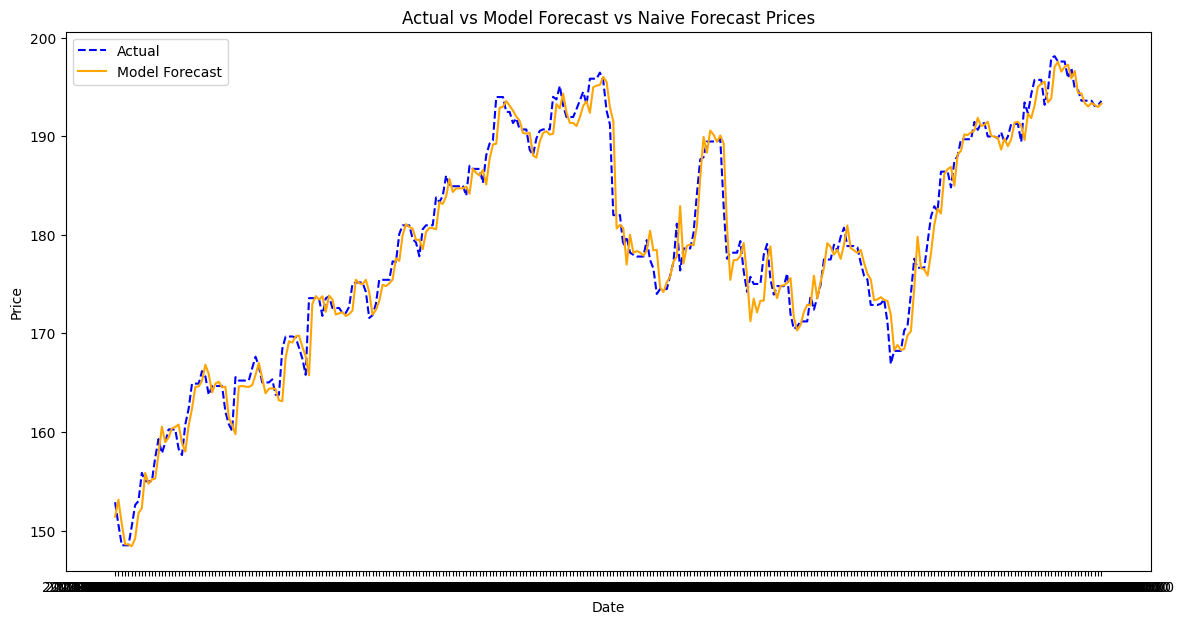

In [76]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [77]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0           64  3.589315  0.362712            0.494915   

   actual_direction_accuracy  direction_profit     profit  
0                   0.562712         17.715661  13.954505  


In [78]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

26.630475576753682